## Projekt - klasyfikacja dźwięków środowiskowych
Celem projektu jest stworzenie modelu klasyfikacjnego umożliwiającego rozpoznanie dźwieków takich jak: szczekanie psa, płacz dziecka, deszcz i inne.  
Dane pochodzą ze zbioru [ESC50](https://www.kaggle.com/mmoreaux/environmental-sound-classification-50), [Link to the license](https://creativecommons.org/licenses/by-nc-sa/4.0/).
W projekcie została wykorzystana ograniczona wersja zbioru - ESC10.  
W zbiorze ESC10 znajduje się 10 klas: ['dog' 'chainsaw' 'crackling_fire' 'helicopter' 'rain' 'crying_baby'
 'clock_tick' 'sneezing' 'rooster' 'sea_waves']. W każdej klasie znajduje się 40, 5-cio sekundowych nagrań .wav.

Spis treści:
1. [Wstęp](#Projekt---klasyfikacja-dźwięków-środowiskowych)
2. [Prametryzacja danych](#Parametryzacja-danych)
3. [KNN](#KNN)
4. [SVM](#SVM)
5. [Random Forest](#RandomForest)
6. [LGBM](#LGBM)
7. [Podsumowanie](#Podsumowanie)
8. [CNN](#CNN)

In [1]:
import os
import librosa
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, make_scorer, plot_confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb

In [2]:
csv_filepath = 'esc50.csv'
data_path = 'audio/audio/16000/'

In [3]:
df = pd.read_csv(csv_filepath)
print(df.shape)
df.head()

(2000, 7)


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
df = df[df['esc10']==True]

classes = df['category'].unique()
classes_dict = {v:k for k,v in enumerate(classes)}
df['target'] = df['category'].map(classes_dict)

df = df.drop(['fold','esc10','src_file','take'], axis=1)

print("Dataframe shape: {}".format(df.shape))
print("Classes: {}".format(classes))
df

Dataframe shape: (400, 3)
Classes: ['dog' 'chainsaw' 'crackling_fire' 'helicopter' 'rain' 'crying_baby'
 'clock_tick' 'sneezing' 'rooster' 'sea_waves']


,filename,target,category
0,1-100032-A-0.wav,0,dog
14,1-110389-A-0.wav,0,dog
24,1-116765-A-41.wav,1,chainsaw
54,1-17150-A-12.wav,2,crackling_fire
55,1-172649-A-40.wav,3,helicopter
...,...,...,...
1876,5-233160-A-1.wav,8,rooster
1888,5-234879-A-1.wav,8,rooster
1889,5-234879-B-1.wav,8,rooster
1894,5-235671-A-38.wav,6,clock_tick


## Parametryzacja danych
Dane zostały sparamteryzowane przy użyciu MFCC oraz delt i 2-gich delt.

In [5]:
mfcc_params = {'n_mfcc': 13, 'n_fft': 512, 'win_length': 320, 'hop_length': 160}

In [27]:
mfccs, y = [], []
for row in df.iterrows(): # (index, (filename, target, category))
    x, fs = librosa.load(os.path.join(data_path, row[1][0]), sr=None)
    mfcc = librosa.feature.mfcc(y=x, sr=fs, **mfcc_params)[1:]
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfccs.append(np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0))
    y.append(row[1][1])

In [28]:
X = np.stack([mfcc for mfcc in mfccs], axis=0)
print(X.shape)

(400, 36, 501)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modele kalsyfikacyjne

Modele będą oceniane na podstawie 2 metryk: accuracy - ponieważ wskazuje dokładny stosunek obektów poprawnie zaklasyfikowanych do niepoprawnie zaklasyfikowanych, oraz F1-score ponieważ wskazuje trochę szerszy obraz sytuacji z uśrednianiem macro, ponieważ w każdej klasie znajduje się tyle samo obiektów. 

In [10]:
def calculate_metrics(y_test, y_pred):
    print("Classification accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Classification F1-score: {:.2f}".format(f1_score(y_test, y_pred, average='macro')))

#### KNN

Classification accuracy: 0.53
Classification F1-score: 0.47


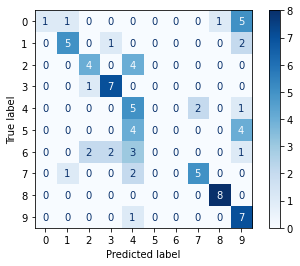

In [11]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
plot_confusion_matrix(neigh, X_test, y_test, cmap='Blues')
calculate_metrics(y_test, y_pred)

Biorąc pod uwagę złożoność problemu (10 klas) model KNN zwrócił nie nargorsze wyniki. Jednak jak można zauważyć na powyższym wykresie model nie radzi sobię z klasyfikacją do klas 0, 5 i 6 ('dog', 'crying_baby', 'clock_tick'). W tym celu zostaną przetestowane inne modele.

#### SVM

In [12]:
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_f1_macro'])

def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1)}
    return space

In [13]:
model = SVC
trials = 15
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)

[I 2021-12-25 11:20:40,508] A new study created in memory with name: no-name-0e0afc5d-20c6-49f8-be3a-6913ebb47ede
[I 2021-12-25 11:20:58,258] Trial 0 finished with value: 0.43089693502232207 and parameters: {'C': 0.7309444716034309}. Best is trial 0 with value: 0.43089693502232207.
[I 2021-12-25 11:21:15,577] Trial 1 finished with value: 0.3209644224323858 and parameters: {'C': 0.4176705887408314}. Best is trial 0 with value: 0.43089693502232207.
[I 2021-12-25 11:21:32,595] Trial 2 finished with value: 0.36733473124393834 and parameters: {'C': 0.5236325770540685}. Best is trial 0 with value: 0.43089693502232207.
[I 2021-12-25 11:21:50,053] Trial 3 finished with value: 0.3165879124689194 and parameters: {'C': 0.39060081274664715}. Best is trial 0 with value: 0.43089693502232207.
[I 2021-12-25 11:22:06,923] Trial 4 finished with value: 0.2622753009661746 and parameters: {'C': 0.10630126181368937}. Best is trial 0 with value: 0.43089693502232207.
[I 2021-12-25 11:22:23,388] Trial 5 finish

Classification accuracy: 0.64
Classification F1-score: 0.63


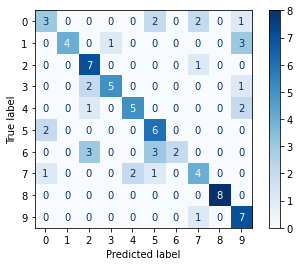

In [14]:
SVM = SVC(**study.best_params)
SVM.fit(X_train_scaled, y_train)
y_pred = SVM.predict(X_test_scaled)
plot_confusion_matrix(SVM, X_test_scaled, y_test, cmap='Blues')
calculate_metrics(y_test, y_pred)

Model SVM znacznie lepiej poradził sobię z problemem (F1-score większe o 0.16). Zniknął problem z klasą 5, jednak model wciąż nie najlepiej radzi sobię z klasą 0 i 6.

#### RandomForest

In [15]:
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

def objective(trial, model, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_f1_macro'])

def get_space(trial): 
    space = {"n_estimators": trial.suggest_int("n_estimators", 2, 200),
             "max_depth": trial.suggest_int("max_depth", 2, 200),
             "min_samples_split": trial.suggest_int("min_samples_split", 5, 15),
             "n_jobs": trial.suggest_int("n_jobs", -1, -1)}
    return space

In [16]:
model = RandomForestClassifier
trials = 60
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, X_train_scaled, y_train), n_trials=trials)

[I 2021-12-25 11:24:44,386] A new study created in memory with name: no-name-dea93498-6ab5-414c-9c85-459a134087b7
[I 2021-12-25 11:24:49,697] Trial 0 finished with value: 0.4767212082722919 and parameters: {'n_estimators': 31, 'max_depth': 22, 'min_samples_split': 10, 'n_jobs': -1}. Best is trial 0 with value: 0.4767212082722919.
[I 2021-12-25 11:24:53,136] Trial 1 finished with value: 0.49710762818193166 and parameters: {'n_estimators': 65, 'max_depth': 123, 'min_samples_split': 12, 'n_jobs': -1}. Best is trial 1 with value: 0.49710762818193166.
[I 2021-12-25 11:24:56,143] Trial 2 finished with value: 0.4786157067906294 and parameters: {'n_estimators': 40, 'max_depth': 155, 'min_samples_split': 7, 'n_jobs': -1}. Best is trial 1 with value: 0.49710762818193166.
[I 2021-12-25 11:25:02,147] Trial 3 finished with value: 0.5354176934176934 and parameters: {'n_estimators': 197, 'max_depth': 109, 'min_samples_split': 13, 'n_jobs': -1}. Best is trial 3 with value: 0.5354176934176934.
[I 2021-

[I 2021-12-25 11:27:50,562] Trial 35 finished with value: 0.5126840708311297 and parameters: {'n_estimators': 198, 'max_depth': 112, 'min_samples_split': 13, 'n_jobs': -1}. Best is trial 21 with value: 0.5563599061756956.
[I 2021-12-25 11:27:54,679] Trial 36 finished with value: 0.49322130157424277 and parameters: {'n_estimators': 89, 'max_depth': 121, 'min_samples_split': 9, 'n_jobs': -1}. Best is trial 21 with value: 0.5563599061756956.
[I 2021-12-25 11:28:01,066] Trial 37 finished with value: 0.4981442119971531 and parameters: {'n_estimators': 187, 'max_depth': 102, 'min_samples_split': 14, 'n_jobs': -1}. Best is trial 21 with value: 0.5563599061756956.
[I 2021-12-25 11:28:07,683] Trial 38 finished with value: 0.5210082629788512 and parameters: {'n_estimators': 199, 'max_depth': 158, 'min_samples_split': 10, 'n_jobs': -1}. Best is trial 21 with value: 0.5563599061756956.
[I 2021-12-25 11:28:12,174] Trial 39 finished with value: 0.5288622227445757 and parameters: {'n_estimators': 142

Classification accuracy: 0.61
Classification F1-score: 0.60


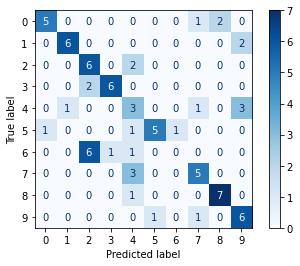

In [17]:
model = RandomForestClassifier(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
plot_confusion_matrix(model, X_test_scaled, y_test, cmap='Blues')
calculate_metrics(y_test, y_pred)

Model Random Forest zwraca gorsze wyniki niż SVM. Prawdopodobnie szerzej zakrojone poszukiwania optymalnych hiperparametrów mogłyby poprawić sytuację, jednak nie uważam, że poprawiłyby ją na tyle, aby warto było ich poszukiwać.

#### LGBM

In [25]:
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

def get_space(trial): 
    space = {"boosting_type": trial.suggest_categorical('boosting_type', ["gbdt"]),
            "num_leaves": trial.suggest_int("num_leaves", 2, 200),
            "n_estimators": trial.suggest_int("n_estimators", 2, 200),
            "max_depth": trial.suggest_int("max_depth", 2, 200),
            "learning_rate": trial.suggest_discrete_uniform("learning_rate", 0.00001, 1, 0.0001),
            "subsample": trial.suggest_discrete_uniform("subsample", 0.01, 1, 0.01),
            "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.01, 1, 0.01),
            "min_split_gain": trial.suggest_discrete_uniform("min_split_gain", 0.01, 1, 0.01),
            "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
            "n_jobs": trial.suggest_int("n_jobs", -1, -1)}
    return space

def objective(trial, model, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_f1_macro'])

In [31]:
model = lgb.LGBMClassifier
trials = 30
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, X_train_scaled, y_train), n_trials=trials)

[I 2021-12-25 11:59:35,661] A new study created in memory with name: no-name-79be9df3-af2a-4d1d-b62d-06ce42c5cc48
C:\Users\kukli\.conda\envs\PUM\lib\site-packages\optuna\distributions.py:547: UserWarning: The distribution is specified by [1e-05, 1] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.99991].
  warnings.warn(
[I 2021-12-25 12:00:59,992] Trial 0 finished with value: 0.4218220632137041 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 155, 'n_estimators': 165, 'max_depth': 197, 'learning_rate': 0.30241, 'subsample': 0.21000000000000002, 'colsample_bytree': 0.79, 'min_split_gain': 0.28, 'min_child_samples': 44, 'n_jobs': -1}. Best is trial 0 with value: 0.4218220632137041.
C:\Users\kukli\.conda\envs\PUM\lib\site-packages\optuna\distributions.py:547: UserWarning: The distribution is specified by [1e-05, 1] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.99991].
  warnings.warn(
[I 2021-12-25 12:02:

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


[I 2021-12-25 12:08:09,413] Trial 8 finished with value: 0.3934301939890176 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 31, 'n_estimators': 169, 'max_depth': 148, 'learning_rate': 0.45631000000000005, 'subsample': 0.44, 'colsample_bytree': 0.79, 'min_split_gain': 0.6, 'min_child_samples': 45, 'n_jobs': -1}. Best is trial 2 with value: 0.4545215615138215.
C:\Users\kukli\.conda\envs\PUM\lib\site-packages\optuna\distributions.py:547: UserWarning: The distribution is specified by [1e-05, 1] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.99991].
  warnings.warn(
[I 2021-12-25 12:08:39,467] Trial 9 finished with value: 0.4245936481818835 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'n_estimators': 10, 'max_depth': 104, 'learning_rate': 0.052110000000000004, 'subsample': 0.67, 'colsample_bytree': 0.64, 'min_split_gain': 0.7100000000000001, 'min_child_samples': 11, 'n_jobs': -1}. Best is trial 2 with value: 0.4545215615138215.


C:\Users\kukli\.conda\envs\PUM\lib\site-packages\optuna\distributions.py:547: UserWarning: The distribution is specified by [1e-05, 1] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.99991].
  warnings.warn(
[I 2021-12-25 12:27:19,433] Trial 22 finished with value: 0.49660125220496737 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 200, 'n_estimators': 112, 'max_depth': 87, 'learning_rate': 0.01091, 'subsample': 0.99, 'colsample_bytree': 0.43, 'min_split_gain': 0.36000000000000004, 'min_child_samples': 6, 'n_jobs': -1}. Best is trial 16 with value: 0.5225924587967932.
C:\Users\kukli\.conda\envs\PUM\lib\site-packages\optuna\distributions.py:547: UserWarning: The distribution is specified by [1e-05, 1] and q=0.0001, but the range is not divisible by `q`. It will be replaced by [1e-05, 0.99991].
  warnings.warn(
[I 2021-12-25 12:28:08,221] Trial 23 finished with value: 0.4620592329926695 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 

Classification accuracy: 0.66
Classification F1-score: 0.65


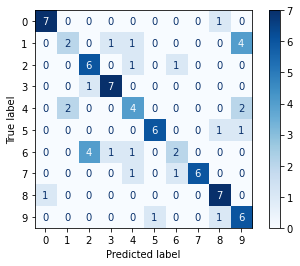

In [32]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
plot_confusion_matrix(model, X_test_scaled, y_test, cmap='Blues')
calculate_metrics(y_test, y_pred)

Model LGBM zdecydowanie najlepiej poradził sobię z problemem. Jednak wciąż występują problemy z klasą 1 i 6 ('chainsaw', 'clock_tick'). 

#### Podsumowanie

Na podstawie MFCC zostały wytrenowane 4 modele: KNN, Random Forest, SVM, LGBM. Najlpesze wyniki zwrócił model model LGBM: dokładność: 66%, F1-score: 0.65. Jednak wartości tych metryk są zabużone przez 2 klasy: 'chainsaw' i 'clock_tick', gdyż pozostałe klasy osiągały dokładność większą niż 6/8 - 75%, co jest satusfakcjonującym wynikiem. Żaden z trenowanych modeli nie poradził sobię z klasyfikacją tych klas. Prawdopodobnie powodem tak niskich wyników jest fakt, iż współczynniki MFCC nie oddają poprawnie ich charakterystych. W celu poprawienia wyników należałoby wytrenować powyższe modele na innych cechach sygnałów. Jest również prawdopodobne, że powyższe modele nie radzą sobię z taką klasyfikacją, zatem w celu poprawienia wyników należy wytrenować inny model lub sieć neuronową.

#### CNN

In [21]:
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

X, y = [], []
for row in df.iterrows(): # (index, (filename, target, category))
    x, fs = librosa.load(os.path.join(data_path, row[1][0]), sr=None)
    mfcc = librosa.feature.mfcc(y=x, sr=fs, **mfcc_params)[1:]
    X.append(mfcc)
    y.append(row[1][1])

X = np.array(X)
y = np.array(y)

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = tf.keras.utils.to_categorical(y, num_classes=10)
print(X.shape, y.shape)

input_shape = X.shape[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

(400, 12, 501, 1) (400, 10)


In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='valid', input_shape=input_shape),  
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3), activation='relu', padding='valid'),
    layers.Dropout(0.3),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='acc')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 499, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 497, 128)       36992     
                                                                 
 dropout (Dropout)           (None, 8, 497, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 495, 128)       147584    
                                                                 
 dropout_1 (Dropout)         (None, 6, 495, 128)       0         
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                        

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=60,
                    #callbacks = [callback],
                    batch_size=32)

Epoch 1/60
10/10 [==============================] - 11s 979ms/step - loss: 2.2857 - acc: 0.1625 - val_loss: 2.0070 - val_acc: 0.3375
Epoch 2/60
10/10 [==============================] - 9s 950ms/step - loss: 1.8438 - acc: 0.3375 - val_loss: 1.7119 - val_acc: 0.4000
Epoch 3/60
10/10 [==============================] - 10s 984ms/step - loss: 1.5598 - acc: 0.4812 - val_loss: 1.5985 - val_acc: 0.4500
Epoch 4/60
10/10 [==============================] - 10s 979ms/step - loss: 1.4007 - acc: 0.5031 - val_loss: 1.5317 - val_acc: 0.4125
Epoch 5/60
10/10 [==============================] - 10s 971ms/step - loss: 1.2471 - acc: 0.5719 - val_loss: 1.2870 - val_acc: 0.5875
Epoch 6/60
10/10 [==============================] - 10s 979ms/step - loss: 1.1709 - acc: 0.5875 - val_loss: 1.4672 - val_acc: 0.4375
Epoch 7/60
10/10 [==============================] - 10s 972ms/step - loss: 1.0773 - acc: 0.6531 - val_loss: 1.3592 - val_acc: 0.5750
Epoch 8/60
10/10 [==============================] - 10s 973ms/step - l

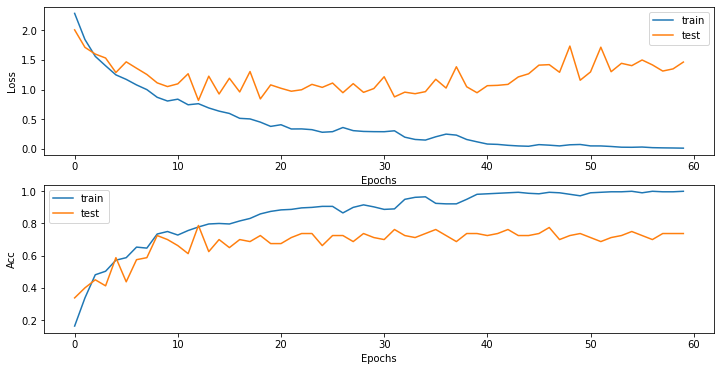

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(['train', 'test'])

ax[1].plot(history.history['acc'])
ax[1].plot(history.history['val_acc'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Acc')
ax[1].legend(['train', 'test'])

plt.show()

Jak można zauważyć na powyższym wykresie, sieć CNN znacznie lepiej poradziła sobię z problemem niż inne modele klasyfikacyjne, osiągając dokładność walidacji ok. 78%. Warto zauważyć, że architektura sieci nie jest zbyt skomplikowana, więc pozostawia miejsce do dalszych ulepszeń.